## Example convection script from dedalus website  
https://dedalus-project.readthedocs.io/en/latest/pages/examples/ivp_2d_rayleigh_benard.html

In [1]:
import matplotlib.pyplot as plt
import time
from pathlib import Path
import h5py
import os
import numpy as np
import matplotlib.colors as colors
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

The problem is non-dimensionalized using the box height and freefall time, so
the resulting thermal diffusivity and viscosity are related to the Prandtl
and Rayleigh numbers as:

    kappa = (Rayleigh * Prandtl)**(-1/2)
    nu = (Rayleigh / Prandtl)**(-1/2)

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""



# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = 2e6
Prandtl = 1
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Rayleigh * Prandtl)**(-1/2)
nu = (Rayleigh / Prandtl)**(-1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = - u@grad(b)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
problem.add_equation("b(z=0) = Lz")
problem.add_equation("u(z=0) = 0")
problem.add_equation("b(z=Lz) = 0")
problem.add_equation("u(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
b['g'] *= z * (Lz - z) # Damp noise at walls
b['g'] += Lz - z # Add linear background

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2025-05-27 17:41:40,533 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 16s, Rate: 7.9e+00/s
2025-05-27 17:41:41,230 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 7s, Rate: 1.6e+01/s
2025-05-27 17:41:41,982 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 6s, Rate: 1.7e+01/s
2025-05-27 17:41:42,692 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 5s, Rate: 1.7e+01/s
2025-05-27 17:41:43,352 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 3s, Remaining: 4s, Rate: 1.8e+01/s
2025-05-27 17:41:44,055 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 4s, Remaining: 4s, Rate: 1.8e+01/s
2025-05-27 17:41:44,732 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 4s, Remaining: 3s, Rate: 1.8e+01/s
2025-05-27 17:41:45,438 subsystems 0/1 INFO :: Building subprob

mpiexec -n 4 python3 rayleigh_benard.py
mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h

In [3]:
os.listdir("/home/ben2121/Test convection/snapshots/")

['snapshots_s1.h5', 'snapshots_s2.h5', 'snapshots_s4.h5', 'snapshots_s3.h5']

In [4]:
f = h5py.File("/home/ben2121/Test convection/snapshots/snapshots_s1.h5", "r")

In [5]:
list(f.keys())

['scales', 'tasks']

In [6]:
sc = f["scales"]
ta = f["tasks"]
print(list(sc.keys()))
print(list(ta.keys()))

['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_259ff677ed0cf648980d6e69fe3d2deb0dc82141', 'z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf']
['buoyancy', 'vorticity']


In [7]:
const = sc["constant"]
itera = sc["iteration"]
sim_t = sc["sim_time"]
times = sc["timestep"]
wall_t = sc["wall_time"]
write_num = ["write_number"]
x_hash = sc["x_hash_259ff677ed0cf648980d6e69fe3d2deb0dc82141"]
z_hash = sc["z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf"]

buoy = ta["buoyancy"]
vort = ta["vorticity"]
print(x_hash.shape)
print(buoy)

(256,)
<HDF5 dataset "buoyancy": shape (50, 256, 64), type "<f8">


print(len(buoy[0,:,0]))
print(buoy[0,:,0])
buoy1 = buoy[0,:,0]
print(len(buoy1))
print(buoy1)

In [8]:
print(sim_t[:])

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25]


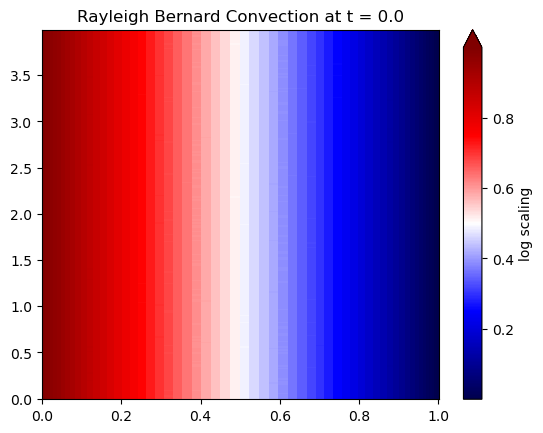

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Rayleigh Bernard Convection at t = {0}".format(sim_t[0]))
X = x_hash
Z = z_hash
pcm = ax.pcolor(Z, X, buoy[0], cmap = "seismic", shading = "nearest")
fig.colorbar(pcm, extend='max', label='log scaling', norm=colors.LogNorm(vmin=buoy[:,0].min(), vmax=buoy[:,0].max()))

In [10]:
buoy[:,0]

array([[9.99849468e-01, 9.98643824e-01, 9.96242602e-01, ...,
        3.75912258e-03, 1.35501776e-03, 1.50689518e-04],
       [9.99848897e-01, 9.98644893e-01, 9.96238784e-01, ...,
        3.76084130e-03, 1.35446773e-03, 1.50149284e-04],
       [9.99849402e-01, 9.98645285e-01, 9.96239937e-01, ...,
        3.76053151e-03, 1.35486284e-03, 1.50588746e-04],
       ...,
       [9.99839604e-01, 9.98557006e-01, 9.95994646e-01, ...,
        3.81543627e-03, 1.37456923e-03, 1.52789683e-04],
       [9.99839978e-01, 9.98560378e-01, 9.96004271e-01, ...,
        3.86578058e-03, 1.39260471e-03, 1.54792640e-04],
       [9.99841928e-01, 9.98577951e-01, 9.96053524e-01, ...,
        3.95445491e-03, 1.42437597e-03, 1.58321136e-04]], shape=(50, 64))

In [19]:

for i in range(len(buoy[:,0])):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot()
    X = x_hash
    Z = z_hash
    ax1.set_title("Rayleigh Bernard Convection at t = {0}".format(sim_t[i]))
    pcm = ax1.pcolor(Z, X, buoy[i], cmap = "seismic", shading = "nearest")
    fig1.colorbar(pcm, extend='max', label='log scaling', norm=colors.LogNorm(vmin=buoy[:,i].min(), vmax=buoy[:,i].max()))
    #fig1.canvas.draw()
    fig1.tight_layout()
    #print(i)
    print('Graph {0}'.format(i+1))
    fig1.savefig("/home/ben2121/Test convection/Figures from example pdf/Graph {0}.pdf".format(i+1))
    fig1.savefig("/home/ben2121/Test convection/Figures from example jpg/Graph {0}.jpg".format(i+1))
    plt.close(fig1) 

Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Graph 10
Graph 11
Graph 12
Graph 13
Graph 14
Graph 15
Graph 16
Graph 17
Graph 18
Graph 19
Graph 20
Graph 21
Graph 22
Graph 23
Graph 24
Graph 25
Graph 26
Graph 27
Graph 28
Graph 29
Graph 30
Graph 31
Graph 32
Graph 33
Graph 34
Graph 35
Graph 36
Graph 37
Graph 38
Graph 39
Graph 40
Graph 41
Graph 42
Graph 43
Graph 44
Graph 45
Graph 46
Graph 47
Graph 48
Graph 49
Graph 50
